# Accident Risk Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Accident Data.csv').drop('id', axis=1)
print(df.shape)

(517754, 13)


In [4]:
df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


## Understanding data

In [5]:
def column_summary(df):
    summary = pd.DataFrame({
        'col_name' : df.columns,
        'col_dtype' : df.dtypes.values,
        'num_of_nulls' : df.isnull().sum().values,
        'null%' : round((df.isnull().sum()/df.shape[0])*100, 2).values,
        'num_of_distinct_values' : df.nunique().values
    })
    return summary

In [6]:
column_summary(df)

,col_name,col_dtype,num_of_nulls,null%,num_of_distinct_values
0,road_type,object,0,0.0,3
1,num_lanes,int64,0,0.0,4
2,curvature,float64,0,0.0,261
3,speed_limit,int64,0,0.0,5
4,lighting,object,0,0.0,3
5,weather,object,0,0.0,3
6,road_signs_present,bool,0,0.0,2
7,public_road,bool,0,0.0,2
8,time_of_day,object,0,0.0,3
9,holiday,bool,0,0.0,2


## Exploratory Data Analysis

### Removing Duplicates

In [7]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)

656


### Univariate Analysis

1. Discrete Numerical Columns:

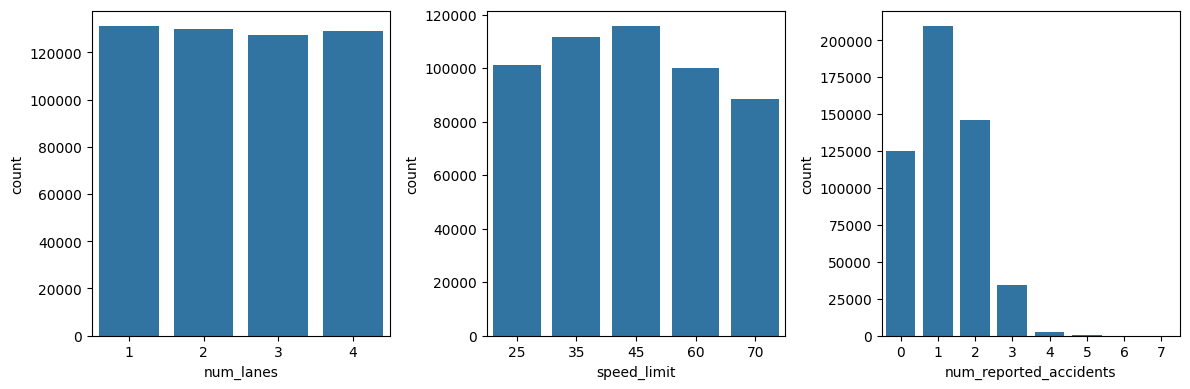

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
cols = ['num_lanes', 'speed_limit', 'num_reported_accidents']

for i, col in enumerate(cols):
    sns.countplot(x=df[col], ax=axs[i])
    
plt.tight_layout()
plt.show()

In [9]:
# outliers detection
df['num_reported_accidents'].value_counts(normalize=True)

num_reported_accidents
1    0.404827
2    0.281960
0    0.242001
3    0.066092
4    0.004624
5    0.000447
6    0.000046
7    0.000004
Name: proportion, dtype: float64

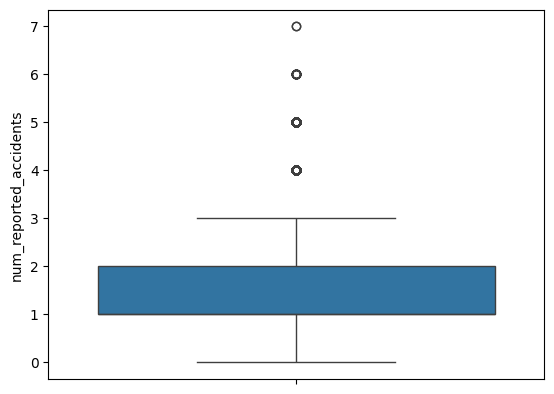

In [10]:
sns.boxplot(df['num_reported_accidents'])
plt.show()

2. Continuous Numerical Columns:

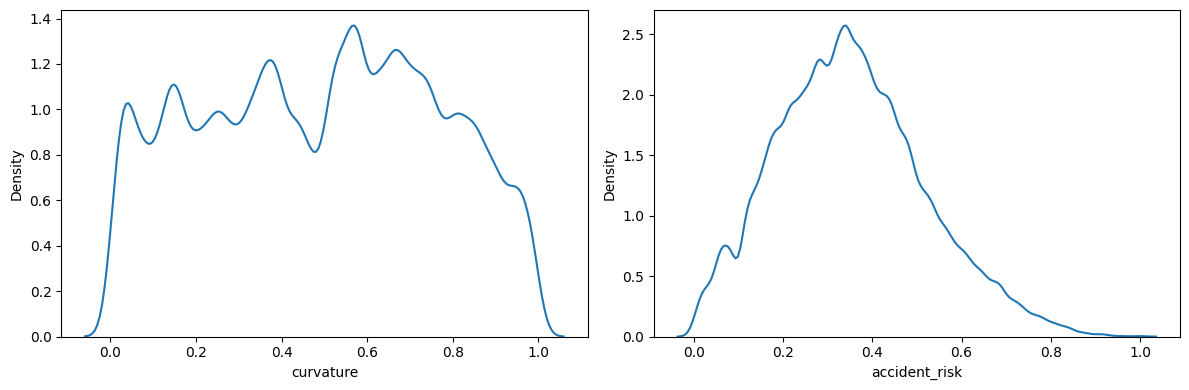

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
cols = ['curvature', 'accident_risk']

for i, col in enumerate(cols):
    sns.kdeplot(x=df[col], ax=axs[i])
    
plt.tight_layout()
plt.show()

**Outliers**

1. Samples having `num_reported_accidents` > 4.
2. Samples having `accident_risk` 100% or 0% are logically incorrect.

In [12]:
# getting num_reported_accidents > 4 & when accident_risk is 1.0 and 0.0
outliers = set(df[df['num_reported_accidents']>4].index.to_list() + 
               df[df['accident_risk']>=1.0].index.to_list() + 
               df[df['accident_risk']<=0.0].index.to_list())
print(len(outliers))

# removing outliers
df = df.drop(index=outliers).reset_index(drop=True)

926


3. Categorical Columns:

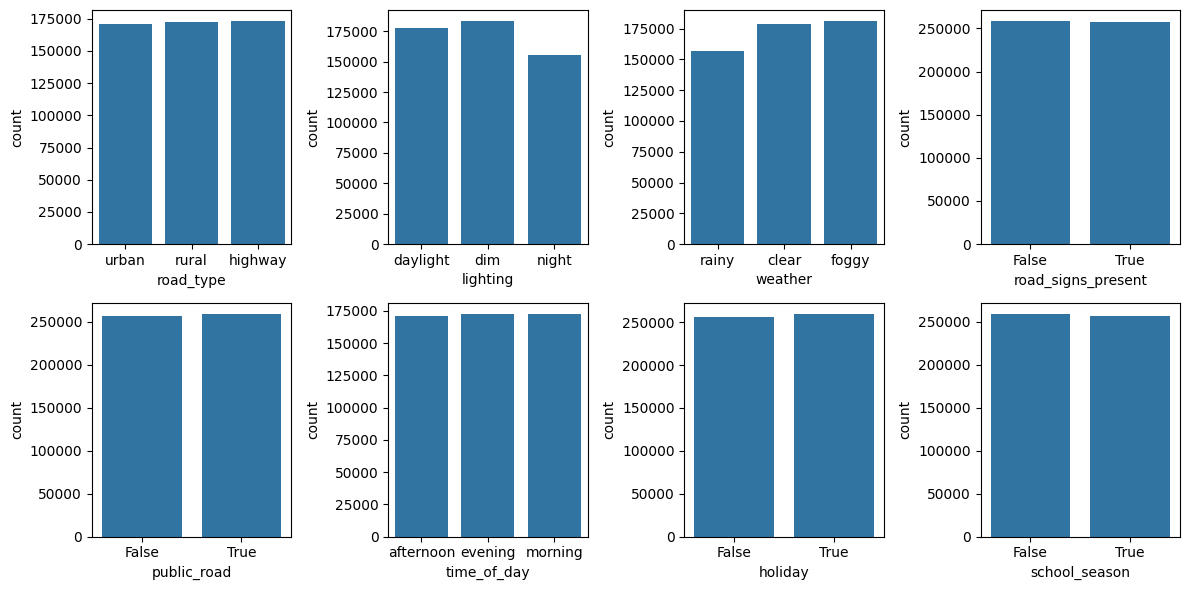

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
cols = ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']

for i, col in enumerate(cols):
    if i<4:
        sns.countplot(x=df[col], ax=axs[0, i])
    else:
        sns.countplot(x=df[col], ax=axs[1, i-4])
    
plt.tight_layout()
plt.show()

### Bivariate Analysis

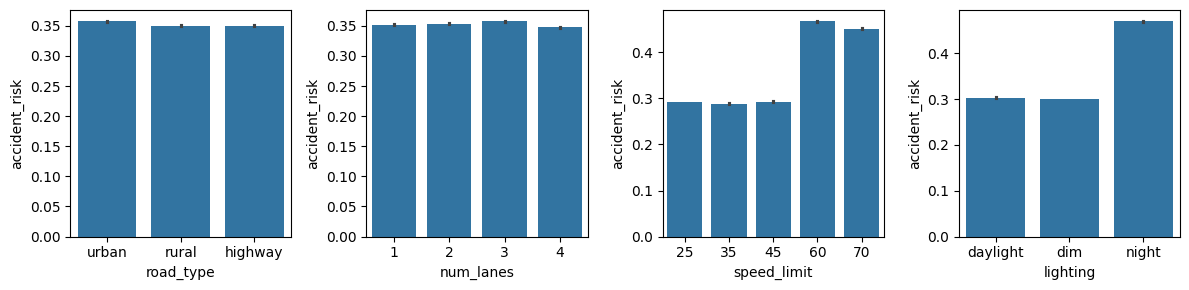

In [14]:
barplot_columns = ['road_type', 'num_lanes', 'speed_limit', 'lighting']

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, col in enumerate(barplot_columns):
    sns.barplot(x=df[col], y=df['accident_risk'], ax=axs[i])

plt.tight_layout()
plt.show()

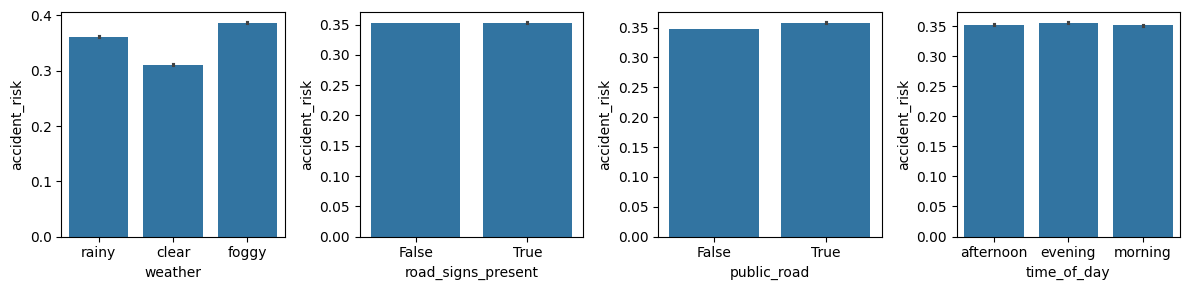

In [15]:
barplot_columns = ['weather', 'road_signs_present', 'public_road', 'time_of_day']

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, col in enumerate(barplot_columns):
    sns.barplot(x=df[col], y=df['accident_risk'], ax=axs[i])

plt.tight_layout()
plt.show()

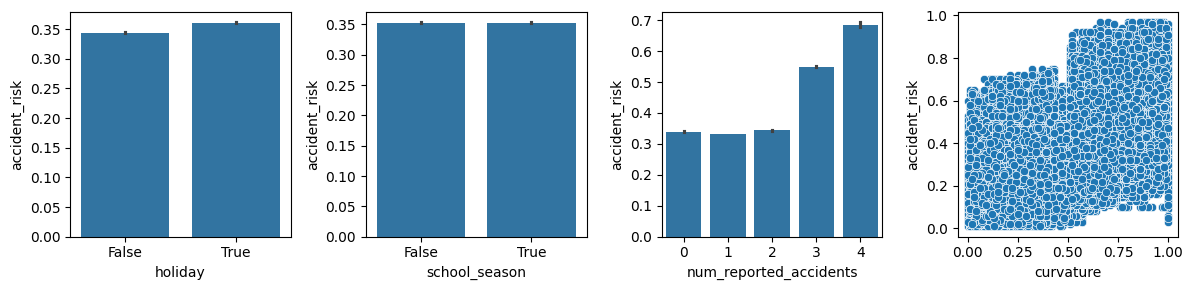

In [16]:
barplot_columns = ['holiday', 'school_season', 'num_reported_accidents']

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, col in enumerate(barplot_columns):
    sns.barplot(x=df[col], y=df['accident_risk'], ax=axs[i])
    
# for scatterplot
sns.scatterplot(x=df['curvature'], y=df['accident_risk'], ax=axs[3])

plt.tight_layout()
plt.show()

**Conclusions:**

* Higher speed limits (above 55) and less lanes tend to increase accident risk.
* Night time and poor weather conditions (rainy, foggy) are risk-prone.
* Urban areas also have higher accident risk.
* More reported accidents are the indicators of risk-prone areas.

## Feature Engineering:

**Transformation of features for better modelling of accident risk.**   

Creating **indexes** as risk indicators of columns.

1. `lightning_index`: 0 for daylight & dim, 1 for night
2. `weather_index`: 0 for clear, 1 for rainy & foggy
3. `speed_index`: 0 if <55, 1 if >55
4. `urbanization_index`: 0 for rural, 1 for non-rural
5. `time_of_day_index`: 0 for morning, 1 for afternoon & evening

Creating **non-linear features** to capture non-linearity.

6. `curvature_speed`: curvature * speed

Combining features to get **densities**.

7. `traffic_density`: urbanization_index * num_lanes
8. `accident_density`: num_reported_accidents / num_lanes

In [17]:
trf_df = df.copy()

In [18]:
# indexes
trf_df['lighting_index'] = trf_df['lighting'].map({'daylight': 0, 'dim': 0, 'night': 1})
trf_df['weather_index'] = trf_df['weather'].map({'clear': 0, 'rainy': 1, 'foggy': 1})
trf_df['speed_index'] = trf_df['speed_limit'].apply(lambda x: 1 if x>=55 else 0)
trf_df['urbanization_index'] = trf_df['road_type'].map({'urban': 1, 'rural': 0, 'highway': 1})
trf_df['time_of_day_index'] = trf_df['time_of_day'].map({'morning': 0, 'afternoon': 1, 'evening': 1})

# non linear transformations
trf_df['curvature_speed'] = trf_df['curvature'] * trf_df['speed_limit']

# densities
trf_df['traffic_density'] = trf_df.apply(lambda row: 1*row['num_lanes'] if row['urbanization_index']==1 else 0.5*row['num_lanes'], axis=1)
trf_df['accident_density'] = round(trf_df['num_reported_accidents'] / trf_df['num_lanes'], 2)

In [19]:
print(trf_df.shape)
trf_df.head()

(516172, 21)


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,...,num_reported_accidents,accident_risk,lighting_index,weather_index,speed_index,urbanization_index,time_of_day_index,curvature_speed,traffic_density,accident_density
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,...,1,0.13,0,1,0,1,1,2.10,2.0,0.50
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,...,0,0.35,0,0,0,1,1,34.65,4.0,0.00
2,rural,4,0.63,70,dim,clear,False,True,morning,True,...,2,0.30,0,0,1,0,0,44.10,2.0,0.50
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,...,1,0.21,0,1,0,1,0,2.45,4.0,0.25
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,...,1,0.56,0,1,1,0,1,34.80,0.5,1.00


In [20]:
column_summary(trf_df)

,col_name,col_dtype,num_of_nulls,null%,num_of_distinct_values
0,road_type,object,0,0.0,3
1,num_lanes,int64,0,0.0,4
2,curvature,float64,0,0.0,261
3,speed_limit,int64,0,0.0,5
4,lighting,object,0,0.0,3
5,weather,object,0,0.0,3
6,road_signs_present,bool,0,0.0,2
7,public_road,bool,0,0.0,2
8,time_of_day,object,0,0.0,3
9,holiday,bool,0,0.0,2


### Engineered Features

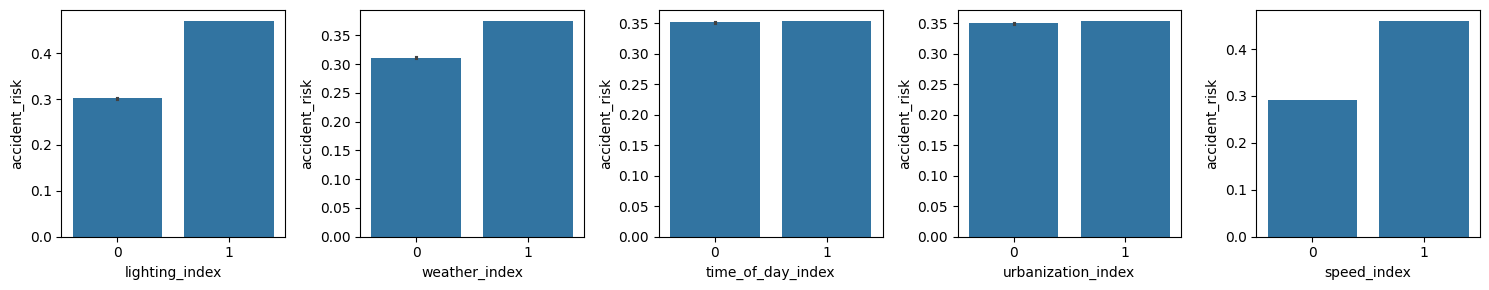

In [21]:
barplot_columns = ['lighting_index', 'weather_index', 'time_of_day_index', 'urbanization_index', 'speed_index']

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, col in enumerate(barplot_columns):
    sns.barplot(x=trf_df[col], y=trf_df['accident_risk'], ax=axs[i])
    
plt.tight_layout()
plt.show()

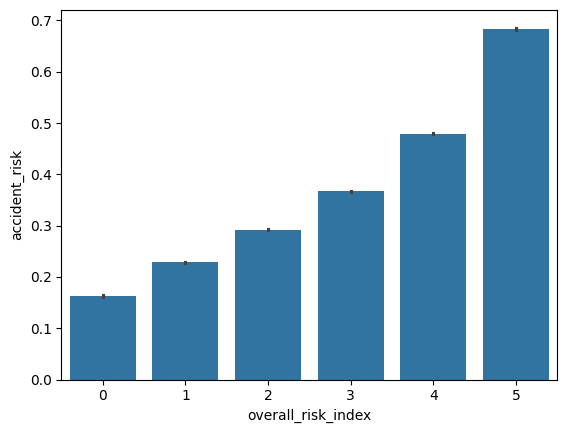

In [22]:
# overall risk index
trf_df['overall_risk_index'] = trf_df['lighting_index'] + trf_df['weather_index'] + trf_df['time_of_day_index'] + trf_df['urbanization_index'] + trf_df['speed_index']

# graph with overall index
sns.barplot(x=trf_df['overall_risk_index'], y=trf_df['accident_risk'])
plt.show()

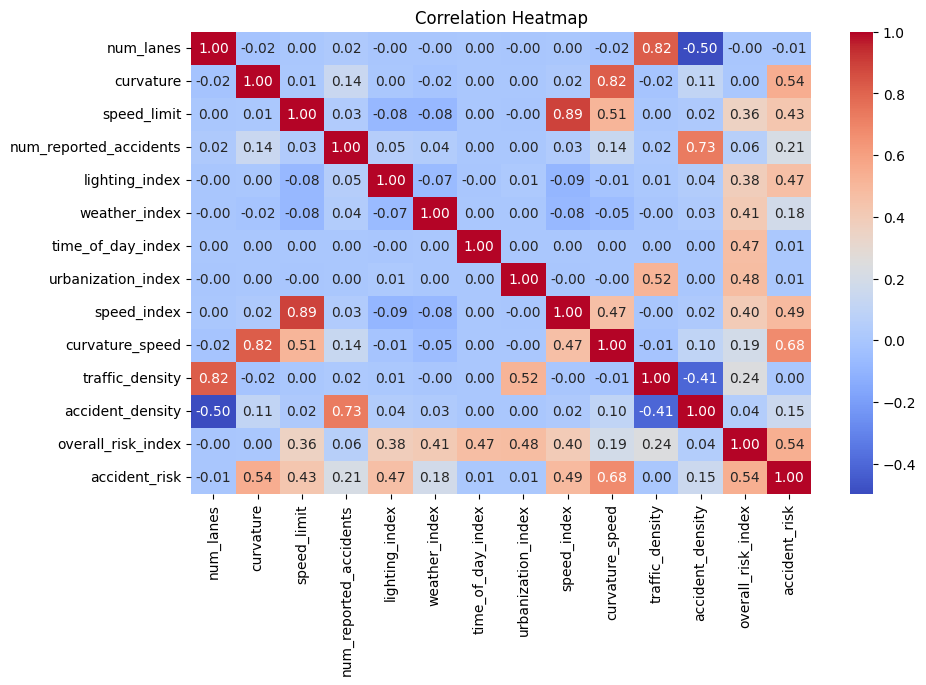

In [23]:
corr_columns = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'lighting_index', 'weather_index', 'time_of_day_index',
'urbanization_index', 'speed_index', 'curvature_speed', 'traffic_density', 'accident_density', 'overall_risk_index', 'accident_risk']

# overall correlation heatmap
plt.figure(figsize=(10, 6))     
sns.heatmap(trf_df[corr_columns].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()